## Assignment

Gold and Silver are two highly correlated commodities, create a strategy (and backtest it, if possible) that tries to identify the relative mispricing of one commodity vs. the other and takes positions accordingly.
Some details:
- Fund AUM: $50 Mln
- A position is immediately stopped if it is losing more than X%

Extra info:
- MaxDD allowed on AUM: -7%
- Target Volatility of the Fund: 10%

## My solution

We start by simply installing the necessary libraries and importing the data.

In [ ]:
pip install -r requirements.txt

In [2]:
import sys
sys.path.append("/Users/giuseppeiannone/assessment-macro-hf/")

In [ ]:
from utils import *
from strategy import *
from backtesting import *

We now download the data for Gold and Silver from Yahoo Finance. We will use the daily closing prices available.
The functions download_data_yfinance and process_yfinance_data are used to download and process the data respectively, to get a dataframe with the daily closing prices of the two commodities.

In [4]:
dictionary = download_data_yfinance(["GC=F", "SI=F"], "2000-01-01", "2025-02-01")

df = process_yfinance_data(dictionary, ["GC=F", "SI=F"], selected_columns=["Date", "Close_GC=F", "Close_SI=F"])

This is our df

In [5]:
df.head()

,Date,Close_GC=F,Close_SI=F
0,2000-08-30,273.899994,4.930
1,2000-08-31,278.299988,5.003
2,2000-09-01,277.000000,5.004
3,2000-09-05,275.799988,4.998
4,2000-09-06,274.200012,4.983


We just do some basic data analysis to check if the data is correct and if there are any missing values.

In [6]:
print(df.isnull().sum())
print((df == 0).sum())

Date          0
Close_GC=F    0
Close_SI=F    0
dtype: int64
Date          0
Close_GC=F    0
Close_SI=F    0
dtype: int64


We compute the daily returns of the two commodities and plot them to see how they look.

In [7]:
df_daily_returns = compute_simple_returns(df, ["Close_GC=F", "Close_SI=F"], shift_days=1)

In [8]:
df = pd.concat([df, df_daily_returns.drop(columns=["Date"])], axis=1)

In [9]:
df.head()

,Date,Close_GC=F,Close_SI=F,Close_GC=F_return,Close_SI=F_return
0,2000-08-30,273.899994,4.930,NaN,NaN
1,2000-08-31,278.299988,5.003,0.016064,0.014807
2,2000-09-01,277.000000,5.004,-0.004671,0.000200
3,2000-09-05,275.799988,4.998,-0.004332,-0.001199
4,2000-09-06,274.200012,4.983,-0.005801,-0.003001


It looks like the two commodities are highly correlated, which is expected. Moreover the data looks clean and there are no missing values.

/var/folders/sb/pr5trk8n2y152hph287lsny00000gn/T/ipykernel_36083/3836914099.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


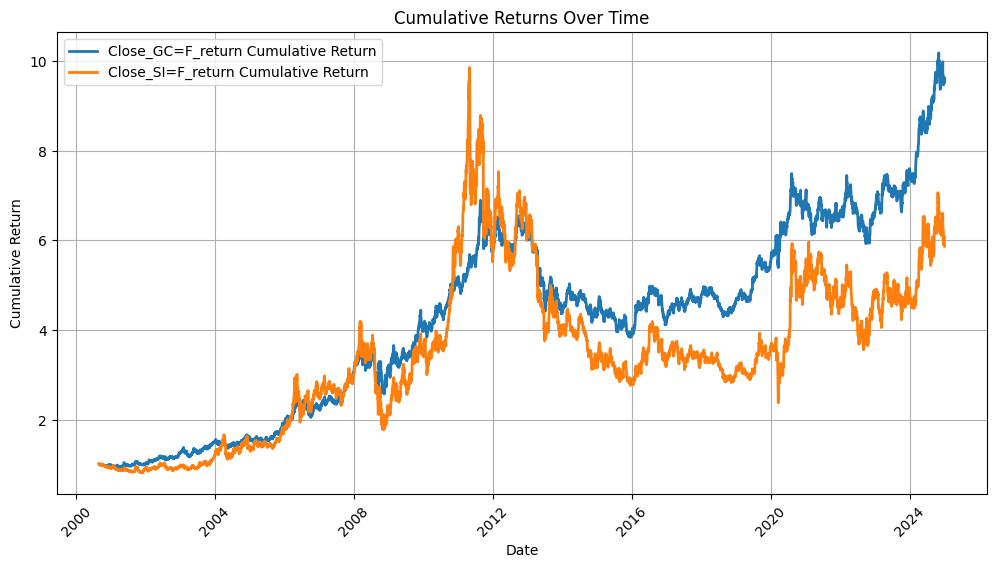

In [23]:
fig = plot_cumulative_returns(df, ["Close_GC=F_return", "Close_SI=F_return"], "2000-01-01", "2025-01-01")
fig.show()

We use this function to tests whether two price series share a long-term equilibrium by checking for stationarity in residuals from an OLS regression. Uses the Augmented Dickey-Fuller test to determine cointegration. Returns `True` if cointegrated, otherwise `False`.
If they are cointegrated, we can use a pairs trading strategy to trade the spread between the two commodities, because the price of 1 commodity is a linear combination of the other.



In [11]:
engle_granger_cointegration_test(df, "Close_GC=F", "Close_SI=F", start_date="2024-10-01", end_date="2024-12-31", p_threshold=0.1)

True

Our strategy will be the following:
- We check if the two commodities are cointegrated for the lookback period of 60 days (so 1 is a linear combination of the other)
- If they are NOT cointegrated, we do not trade, because it's difficult to predict the spread between the two
- If they are cointegrated, we compute the ideal price of one commodity given the other, and we check the residual between the actual price and the ideal price. With this residual we can compute the z-score and if above (or below) a certain threshold we can trade the spread between the two commodities. In particular, if the z-score is above the threshold we short the spread, if it's below we long the spread. We will use a threshold of 2.2 and -2.2.
- The capital allocated to the trade will be a percentage of the AUM proportional to the z-score. In particular we will use a kelly criterion to compute the capital allocated to the trade.
- When the z-score gets below the threshold we close the  position, and we do the same if the 2 time series are not cointegrated anymore.
- Moreover we introduce a stop loss of X%

Here we define our strategy. We use a class. The parameters are quite self explanatory. f_max is the maximum fraction of the AUM that can be allocated to a single trade. the z_threshold is the threshold for the z-score to trade the spread. z_max is the maximum z_score for the kelly criterion (basically for z_score above this value we allocate the maximum capital to the trade).

In [12]:
end_date = pd.to_datetime("2025-01-31")
strategy = PairsTradingStrategy(tickers=["GC=F", "SI=F"], fund_aum = 50e6, stop_loss = -0.1, z_threshold = 2.2, f_max = 0.8, z_max = 3.5, lookback_days = 60, end_date = end_date)

We apply the strategy to the 2025-01-31

In [13]:
strategy.run()

Only one trade executed.


/Users/giuseppeiannone/assessment-macro-hf/strategy.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_log = pd.concat([self.trade_log, new_trade], ignore_index=True)


This is the trade log. We can see that the z-score is below the threshold, so we don't trade.

In [14]:
strategy.trade_log

,date,pos_1,pos_2,price_1,price_2,z_score,capital_trade,value_pos,aum,pnl_realized
0,2025-01-30,0.0,0.0,2823.0,32.363998,-0.290855,0,0.0,50000000.0,0.0


Now we simulate to trade on the 2024-12-31

In [15]:
end_date = pd.to_datetime("2024-12-31")
strategy = PairsTradingStrategy(tickers=["GC=F", "SI=F"], end_date=end_date)
strategy.run()

Only one trade executed.


/Users/giuseppeiannone/assessment-macro-hf/strategy.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_log = pd.concat([self.trade_log, new_trade], ignore_index=True)


We do a trade, long gold and short silver, because the z-score is above the threshold and negative.

In [16]:
strategy.trade_log

,date,pos_1,pos_2,price_1,price_2,z_score,capital_trade,value_pos,aum,pnl_realized
0,2024-12-30,0.0,0.0,2606.100098,29.106001,-1.518177,0,0.0,50000000.0,0.0


We then use our backtesting engine to backtest the strategy for 12 years from 2012-05-01 to 2024-05-30

In [17]:
end_date_backtest = pd.to_datetime("2024-05-30")
start_date_backtest = pd.to_datetime("2012-05-01")

backtesting_engine = BacktestingEngine(strategy)

log_tr = backtesting_engine.run_backtesting(start_date_backtest=start_date_backtest, end_date_backtest=end_date_backtest)

/Users/giuseppeiannone/assessment-macro-hf/strategy.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_log = pd.concat([self.trade_log, new_trade], ignore_index=True)


Starting backtest on 2012-05-01 00:00:00
Only one trade executed.
Processed 100/3037 trading days. Current date: 2012-09-20 00:00:00
Processed 200/3037 trading days. Current date: 2013-02-15 00:00:00
Processed 300/3037 trading days. Current date: 2013-07-11 00:00:00
Processed 400/3037 trading days. Current date: 2013-12-02 00:00:00
Processed 500/3037 trading days. Current date: 2014-04-28 00:00:00
Processed 600/3037 trading days. Current date: 2014-09-18 00:00:00
Processed 700/3037 trading days. Current date: 2015-02-11 00:00:00
Processed 800/3037 trading days. Current date: 2015-07-07 00:00:00
Processed 900/3037 trading days. Current date: 2015-11-25 00:00:00
Processed 1000/3037 trading days. Current date: 2016-04-21 00:00:00
Processed 1100/3037 trading days. Current date: 2016-09-13 00:00:00
Processed 1200/3037 trading days. Current date: 2017-02-08 00:00:00
Processed 1300/3037 trading days. Current date: 2017-07-03 00:00:00
Processed 1400/3037 trading days. Current date: 2017-11-22 

We can show the performance of the strategy

In [18]:
strategy_evaluation = backtesting_engine.compute_metrics(log_tr)
strategy_evaluation

/Users/giuseppeiannone/assessment-macro-hf/backtesting.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log_trade['returns'] = log_trade['returns'].fillna(0)


,Total PnL,Total Return (%),Annualized Return (%),Annualized Volatility (%),Sharpe Ratio,Max Drawdown (%)
0,2.135183e+07,42.703666,3.532828,8.048291,0.438954,6.148047


In this period the strategy has an annualized return of approximately 3.5%, with a volatility of 8% close to the target one of 10% of the fund. The max drawdown is -6% which is below the allowed -7%.

This is the log of the trades

In [19]:
log_tr

,date,pos_1,pos_2,price_1,price_2,z_score,capital_trade,value_pos,aum,pnl_realized,returns
0,2012-05-01,16451.633405,-8.853735e+05,1661.699951,30.877001,-2.392047,2.733768e+07,0.0,50000000.0,0.0,0.000000
1,2012-05-02,15388.453732,-8.316969e+05,1653.400024,30.591999,-2.226286,2.544327e+07,0.0,50115785.650195,115785.650195,0.004235
2,2012-05-03,0.000000,0.000000e+00,1634.199951,29.959000,-2.055230,0.000000e+00,0.0,50346789.846188,231004.195994,0.009079
3,2012-05-04,0.000000,0.000000e+00,1644.699951,30.379999,-1.777920,0.000000e+00,0.0,50346789.846188,0.0,0.000000
4,2012-05-07,0.000000,0.000000e+00,1638.599976,30.072001,-1.604208,0.000000e+00,0.0,50346789.846188,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3032,2024-05-23,-19379.950502,1.494260e+06,2335.000000,30.284000,2.813762,4.525218e+07,0.0,69922481.367523,-438228.671327,-0.009620
3033,2024-05-24,-20737.606180,1.594806e+06,2332.500000,30.330000,3.026506,4.837047e+07,0.0,70039666.518208,117185.150685,0.002590
3034,2024-05-28,-20513.078402,1.511132e+06,2355.199951,31.971001,3.017815,4.831240e+07,0.0,72186001.739,2146335.220792,0.044373
3035,2024-05-29,-24105.245163,1.751809e+06,2340.300049,32.202999,3.419071,5.641351e+07,0.0,72842224.869263,656223.130263,0.013583


This is the plot of our AUM

/var/folders/sb/pr5trk8n2y152hph287lsny00000gn/T/ipykernel_36083/2575636321.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


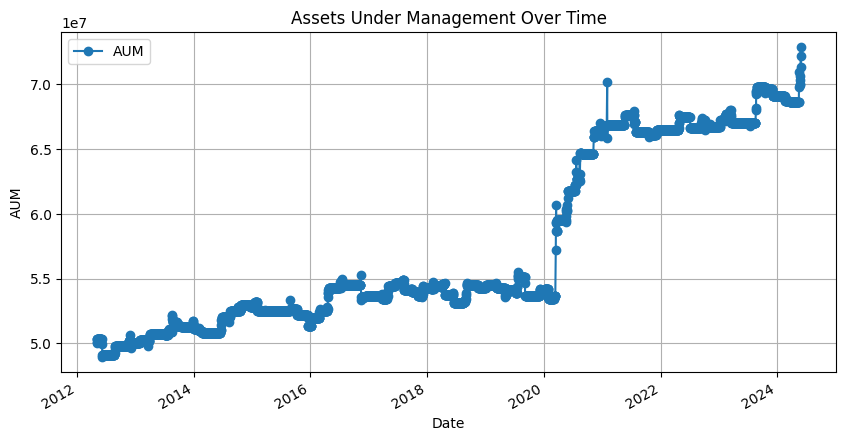

In [20]:
fig = backtesting_engine.plot_aum(log_tr)
fig.show()

This is the plot of the cumulative returns from the beginning to the end of our backtest. Moreover we can see the positions taken by the strategy.


Note that in some situation the positions might look counterintuitive: one might assume that when the spread (difference in prices) widens, the strategy should short the spread (betting it will revert to the mean). However, this is not necessarily the case in our strategy.

Instead of trading based on the absolute size of the spread, our strategy reacts to recent movements in the spread.
If the spread has been increasing consistently over the past lookback days, your model may predict a continuation of this trend (momentum effect), leading to a trade that follows the spread's direction.
Conversely, if the spread has been shrinking, the model might anticipate a further decrease, leading to a trade that continues to push the spread down.
This is different from mean reversion strategies, which assume that the spread will always return to its historical average.

/var/folders/sb/pr5trk8n2y152hph287lsny00000gn/T/ipykernel_36083/1674164490.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


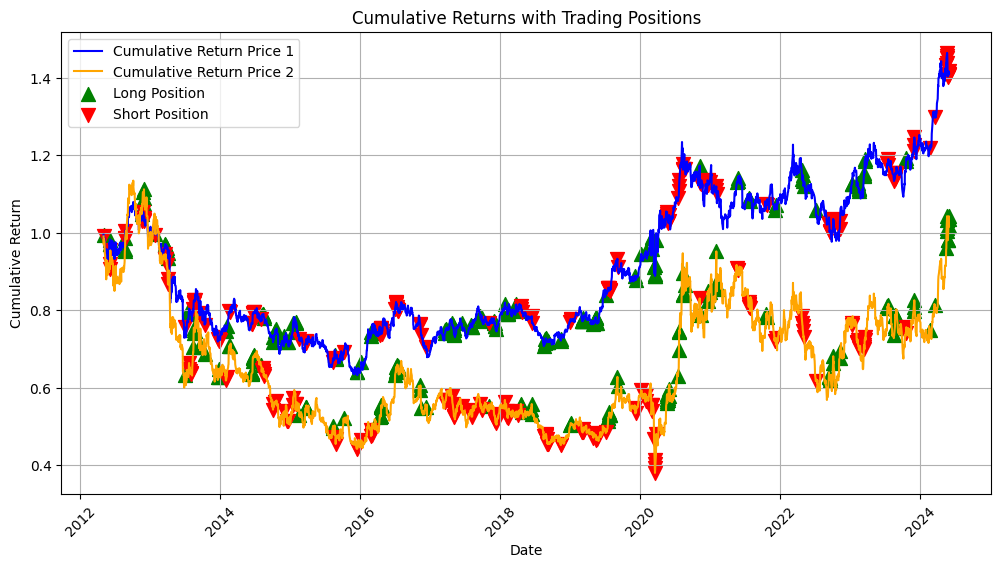

In [21]:
fig = backtesting_engine.plot_cumulative_returns_with_positions(log_tr,['price_1', 'price_2'],['pos_1', 'pos_2'], '2012-05-01', '2024-05-30')

fig.show()

Here we plot it on a shorter period, to observe better the behavior of the strategy.

/var/folders/sb/pr5trk8n2y152hph287lsny00000gn/T/ipykernel_36083/2987898721.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


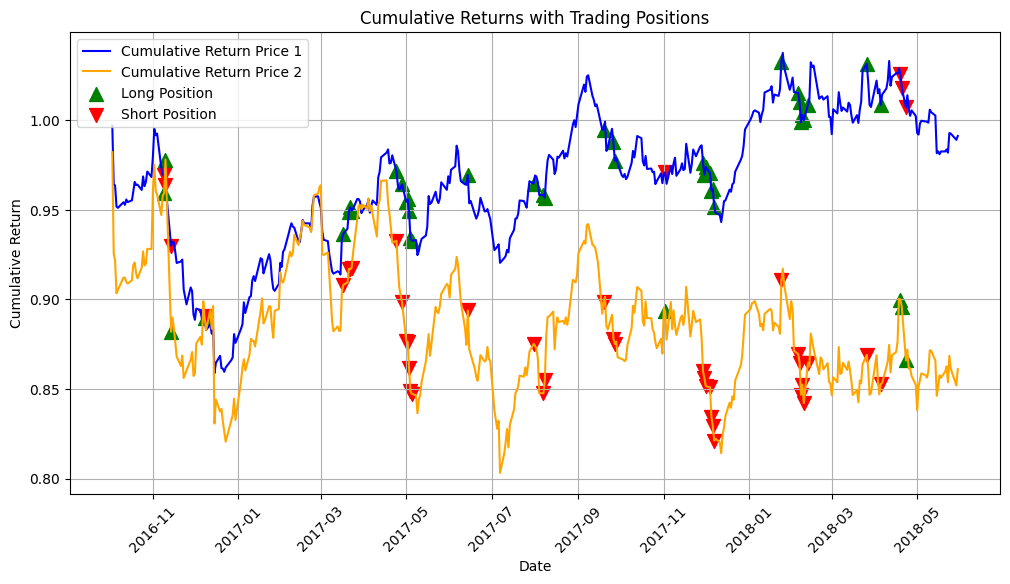

In [22]:
fig = backtesting_engine.plot_cumulative_returns_with_positions(log_tr,['price_1', 'price_2'],['pos_1', 'pos_2'], '2016-10-01', '2018-05-30')

fig.show()